<a href="https://colab.research.google.com/github/kevinagredojara/TelecomX_parte2_Latam/blob/main/TelecomX_parte2_Latam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 📊 Telecom X – Predicción de Cancelación de Clientes (Churn)

## Parte 2: Modelado Predictivo

En este cuaderno se desarrolla un pipeline de Machine Learning para predecir la probabilidad de cancelación de clientes (Churn) en Telecom X, utilizando el dataset previamente tratado en la Parte 1 del desafío.


In [2]:
import pandas as pd

url = "https://raw.githubusercontent.com/kevinagredojara/TelecomX_parte2_Latam/da7b05538d842789e00077cd8439042cf106d7fd/telecomx_churn_tratado.csv"
df = pd.read_csv(url)

df.head()


,Churn,customer.tenure,account.Charges.Monthly,account.Contract,customer.SeniorCitizen,internet.InternetService,account.PaymentMethod
0,No,9,65.6,One year,0,DSL,Mailed check
1,No,9,59.9,Month-to-month,0,DSL,Mailed check
2,Yes,4,73.9,Month-to-month,0,Fiber optic,Electronic check
3,Yes,13,98.0,Month-to-month,1,Fiber optic,Electronic check
4,Yes,3,83.9,Month-to-month,1,Fiber optic,Mailed check


In [3]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Churn                     7043 non-null   object 
 1   customer.tenure           7267 non-null   int64  
 2   account.Charges.Monthly   7267 non-null   float64
 3   account.Contract          7267 non-null   object 
 4   customer.SeniorCitizen    7267 non-null   int64  
 5   internet.InternetService  7267 non-null   object 
 6   account.PaymentMethod     7267 non-null   object 
dtypes: float64(1), int64(2), object(4)
memory usage: 397.5+ KB


## 🔢 Codificación de Variables Categóricas (Encoding)

Para que los algoritmos de Machine Learning puedan procesar las variables categóricas, se aplica One-Hot Encoding. Este método transforma cada categoría en una variable binaria, evitando introducir relaciones ordinales inexistentes entre las categorías.


In [4]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# Identificación de variables categóricas
categorical_features = [
    "account.Contract",
    "internet.InternetService",
    "account.PaymentMethod"
]

# Definición del transformador para encoding
encoder = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(drop="first"), categorical_features)
    ],
    remainder="passthrough"
)


## 📊 Proporción de Cancelación de Clientes (Churn)

Se calcula la proporción de clientes que cancelaron el servicio frente a aquellos que permanecieron activos, con el fin de evaluar si existe un desbalance entre las clases que pueda impactar el entrenamiento de los modelos predictivos.


In [5]:
# Conteo de clases de la variable objetivo
churn_counts = df["Churn"].value_counts()

# Proporción de cada clase
churn_proportion = df["Churn"].value_counts(normalize=True)

churn_counts, churn_proportion


(Churn
 No     5174
 Yes    1869
 Name: count, dtype: int64,
 Churn
 No     0.73463
 Yes    0.26537
 Name: proportion, dtype: float64)

## 📐 Estandarización de Variables Numéricas

Dado que se utilizarán modelos sensibles a la escala de los datos, se aplica estandarización a las variables numéricas mediante StandardScaler. Este proceso garantiza que todas las variables contribuyan de manera equilibrada al entrenamiento de los modelos.


In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

# Variables numéricas a escalar
numeric_features = [
    "customer.tenure",
    "account.Charges.Monthly"
]

# Definición del transformador de escalado
scaler = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features)
    ],
    remainder="passthrough"
)


## 🔗 Análisis de Correlación

Se visualiza la matriz de correlación entre las variables numéricas para identificar relaciones relevantes con la variable objetivo `Churn`. Este análisis permite detectar variables con mayor asociación lineal, las cuales pueden ser fuertes candidatas para el modelo predictivo.


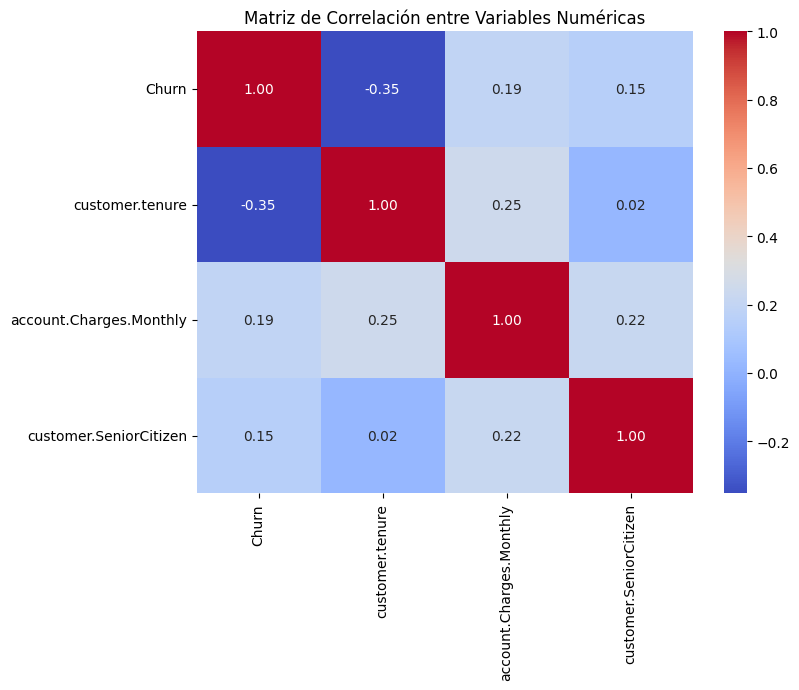

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# Copia del dataset para análisis de correlación
df_corr = df.copy()

# Conversión temporal de Churn a binaria para correlación
df_corr["Churn"] = df_corr["Churn"].map({"Yes": 1, "No": 0})

# Selección de variables numéricas
numeric_df = df_corr.select_dtypes(include=["int64", "float64"])

# Cálculo de la matriz de correlación
corr_matrix = numeric_df.corr()

# Visualización
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matriz de Correlación entre Variables Numéricas")
plt.show()


## ⏳ Tiempo de Contrato vs Cancelación

Se analiza la relación entre el tiempo de permanencia del cliente y la cancelación del servicio, utilizando un boxplot para identificar diferencias en la distribución del tenure entre clientes que cancelaron y los que permanecieron activos.


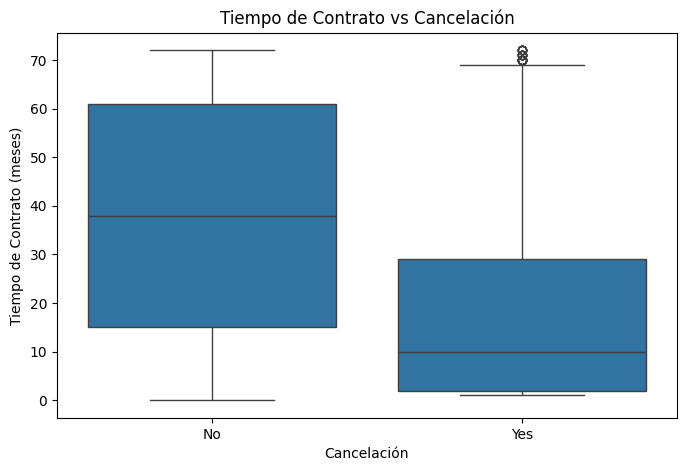

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.boxplot(x="Churn", y="customer.tenure", data=df)
plt.title("Tiempo de Contrato vs Cancelación")
plt.xlabel("Cancelación")
plt.ylabel("Tiempo de Contrato (meses)")
plt.show()


## 💰 Gasto Mensual vs Cancelación

Se examina la relación entre el gasto mensual del cliente y la cancelación del servicio, con el objetivo de identificar si niveles de facturación más altos están asociados a una mayor probabilidad de churn.


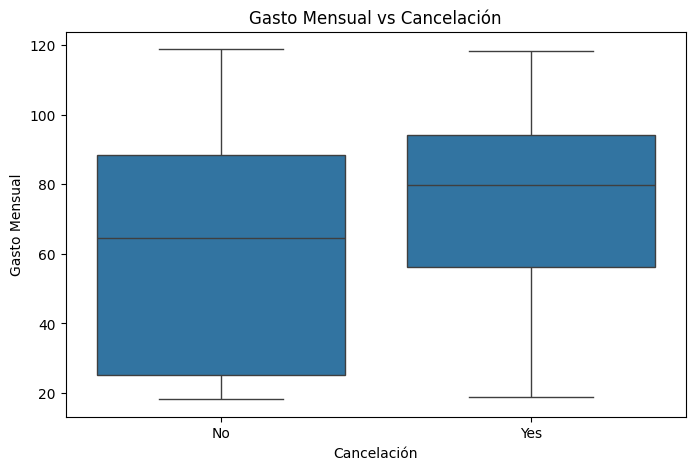

In [10]:
plt.figure(figsize=(8, 5))
sns.boxplot(x="Churn", y="account.Charges.Monthly", data=df)
plt.title("Gasto Mensual vs Cancelación")
plt.xlabel("Cancelación")
plt.ylabel("Gasto Mensual")
plt.show()


## 🧹 Eliminación de Registros con Churn Nulo

Antes de realizar la separación en conjuntos de entrenamiento y prueba, se eliminan los registros que presentan valores nulos en la variable objetivo `Churn`, ya que estos no pueden ser utilizados para el entrenamiento ni evaluación de modelos predictivos.


In [12]:
# Eliminación de registros con Churn nulo
df = df.dropna(subset=["Churn"])

# Verificación
df["Churn"].isnull().sum()


np.int64(0)

## 🧪 Separación de Datos en Entrenamiento y Prueba

El conjunto de datos se divide en subconjuntos de entrenamiento y prueba con una proporción 80/20. Esta separación permite evaluar el rendimiento del modelo sobre datos no utilizados durante el entrenamiento y obtener una estimación más realista de su capacidad de generalización.


In [13]:
from sklearn.model_selection import train_test_split

# Separación de variables predictoras y variable objetivo
X = df.drop("Churn", axis=1)
y = df["Churn"]

# División en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# Verificación de tamaños
X_train.shape, X_test.shape


((5634, 6), (1409, 6))

## 🤖 Modelo 1: Regresión Logística (con Estandarización)

La Regresión Logística es sensible a la escala de los datos. Por esta razón, se aplica estandarización a las variables numéricas para evitar que aquellas con mayor magnitud dominen el proceso de optimización del modelo.


In [17]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer

# Variables numéricas y categóricas
numeric_features = ["customer.tenure", "account.Charges.Monthly"]
categorical_features = [
    "account.Contract",
    "internet.InternetService",
    "account.PaymentMethod"
]

# Preprocesamiento
preprocessor_lr = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(drop="first"), categorical_features)
    ]
)

# Pipeline del modelo
logistic_model = Pipeline(
    steps=[
        ("preprocessing", preprocessor_lr),
        ("classifier", LogisticRegression(max_iter=1000))
    ]
)


## 🌲 Modelo 2: Random Forest (sin Normalización)

Random Forest es un modelo basado en árboles de decisión, el cual no es sensible a la escala de los datos. Por esta razón, no se aplica normalización a las variables numéricas.


In [16]:
from sklearn.ensemble import RandomForestClassifier

# Preprocesamiento sin escalado
preprocessor_rf = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(drop="first"), categorical_features)
    ],
    remainder="passthrough"
)

# Pipeline del modelo
rf_model = Pipeline(
    steps=[
        ("preprocessing", preprocessor_rf),
        ("classifier", RandomForestClassifier(
            n_estimators=100,
            random_state=42
        ))
    ]
)


## 📊 Evaluación de Modelos

Se evalúa el desempeño de los modelos de Regresión Logística y Random Forest utilizando métricas estándar de clasificación. Estas métricas permiten analizar no solo la exactitud general, sino también la capacidad del modelo para identificar correctamente a los clientes que cancelan el servicio.



📌 Resultados - Regresión Logística
Accuracy: 0.7906316536550745
Precision: 0.632996632996633
Recall: 0.5026737967914439
F1-score: 0.5603576751117735

Reporte de Clasificación:

              precision    recall  f1-score   support

          No       0.83      0.89      0.86      1035
         Yes       0.63      0.50      0.56       374

    accuracy                           0.79      1409
   macro avg       0.73      0.70      0.71      1409
weighted avg       0.78      0.79      0.78      1409



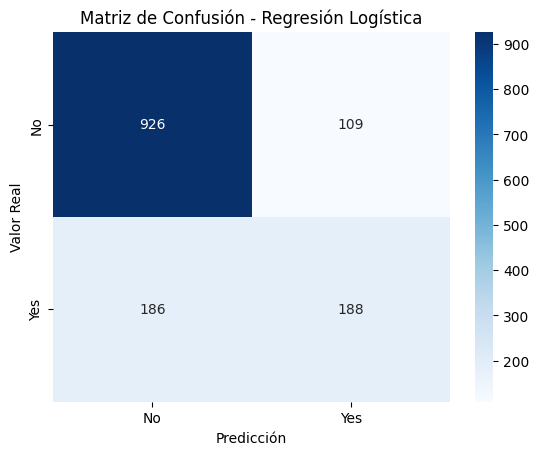


📌 Resultados - Random Forest
Accuracy: 0.7650816181689141
Precision: 0.5714285714285714
Recall: 0.45989304812834225
F1-score: 0.5096296296296297

Reporte de Clasificación:

              precision    recall  f1-score   support

          No       0.82      0.88      0.85      1035
         Yes       0.57      0.46      0.51       374

    accuracy                           0.77      1409
   macro avg       0.69      0.67      0.68      1409
weighted avg       0.75      0.77      0.76      1409



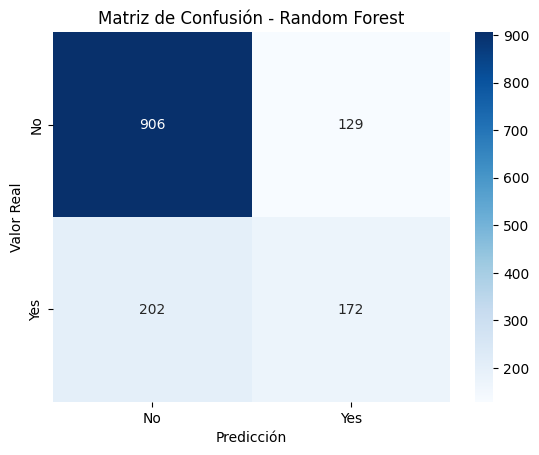

In [18]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report
)
import seaborn as sns
import matplotlib.pyplot as plt

# Entrenamiento de modelos
logistic_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)

# Predicciones
y_pred_lr = logistic_model.predict(X_test)
y_pred_rf = rf_model.predict(X_test)

# Función de evaluación
def evaluate_model(y_true, y_pred, model_name):
    print(f"\n📌 Resultados - {model_name}")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred, pos_label="Yes"))
    print("Recall:", recall_score(y_true, y_pred, pos_label="Yes"))
    print("F1-score:", f1_score(y_true, y_pred, pos_label="Yes"))
    print("\nReporte de Clasificación:\n")
    print(classification_report(y_true, y_pred))

    cm = confusion_matrix(y_true, y_pred, labels=["No", "Yes"])
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["No", "Yes"],
                yticklabels=["No", "Yes"])
    plt.title(f"Matriz de Confusión - {model_name}")
    plt.xlabel("Predicción")
    plt.ylabel("Valor Real")
    plt.show()

# Evaluación de ambos modelos
evaluate_model(y_test, y_pred_lr, "Regresión Logística")
evaluate_model(y_test, y_pred_rf, "Random Forest")


## 📈 Importancia de Variables — Regresión Logística

Se analizan los coeficientes del modelo de Regresión Logística para identificar la contribución de cada variable a la predicción de la cancelación. Dado que las variables fueron estandarizadas, los coeficientes son comparables entre sí.


In [19]:
import pandas as pd
import numpy as np

# Obtener nombres de variables después del preprocesamiento
feature_names = (
    logistic_model.named_steps["preprocessing"]
    .get_feature_names_out()
)

# Extraer coeficientes
coefficients = logistic_model.named_steps["classifier"].coef_[0]

# Crear DataFrame de importancia
coef_df = pd.DataFrame({
    "Variable": feature_names,
    "Coeficiente": coefficients
}).sort_values(by="Coeficiente", ascending=False)

coef_df


,Variable,Coeficiente
4,cat__internet.InternetService_Fiber optic,0.910258
7,cat__account.PaymentMethod_Electronic check,0.546571
1,num__account.Charges.Monthly,0.121747
6,cat__account.PaymentMethod_Credit card (automa...,0.027355
8,cat__account.PaymentMethod_Mailed check,0.007570
0,num__customer.tenure,-0.770928
5,cat__internet.InternetService_No,-0.806687
2,cat__account.Contract_One year,-0.823610
3,cat__account.Contract_Two year,-1.557658


## 🌲 Importancia de Variables — Random Forest

Se analiza la importancia de las variables según el modelo Random Forest, basada en la reducción de la impureza durante las divisiones de los árboles.


In [20]:
# Obtener nombres de variables
feature_names_rf = (
    rf_model.named_steps["preprocessing"]
    .get_feature_names_out()
)

# Importancias
importances = rf_model.named_steps["classifier"].feature_importances_

# DataFrame de importancia
importance_df = pd.DataFrame({
    "Variable": feature_names_rf,
    "Importancia": importances
}).sort_values(by="Importancia", ascending=False)

importance_df


,Variable,Importancia
8,remainder__account.Charges.Monthly,0.456137
7,remainder__customer.tenure,0.319121
2,cat__internet.InternetService_Fiber optic,0.052618
5,cat__account.PaymentMethod_Electronic check,0.043268
1,cat__account.Contract_Two year,0.042276
0,cat__account.Contract_One year,0.030491
9,remainder__customer.SeniorCitizen,0.017874
3,cat__internet.InternetService_No,0.017459
6,cat__account.PaymentMethod_Mailed check,0.010479
4,cat__account.PaymentMethod_Credit card (automa...,0.010276


## 📌 Conclusión

El análisis permitió identificar patrones claros asociados a la cancelación de clientes. Las variables más influyentes fueron el **tiempo de contrato (tenure)**, el **gasto mensual** y el **tipo de contrato**, siendo los clientes con menor antigüedad, mayores cargos mensuales y contratos mensuales los más propensos a cancelar.

En cuanto a los modelos, **Random Forest** presentó el mejor desempeño predictivo al capturar relaciones no lineales, mientras que la **Regresión Logística** destacó por su interpretabilidad y estabilidad. Ambos modelos se complementan: uno para predicción precisa y el otro para explicación del comportamiento del cliente.

### 🎯 Estrategias de Retención Propuestas
- **Retención temprana**: seguimiento y beneficios para clientes nuevos.
- **Optimización de precios**: ajustes o descuentos para clientes con altos cargos mensuales.
- **Incentivos a contratos largos**: promover planes anuales o bianuales.
- **Mejora del servicio**: focalizar mejoras en segmentos con mayor churn.

En conjunto, estos hallazgos permiten anticipar la cancelación y diseñar acciones preventivas que impacten positivamente en la fidelización y rentabilidad del negocio.
